In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

import warnings
warnings.filterwarnings("ignore")

from arch import arch_model 
from tqdm import tqdm

# Загрузка данных

Функция грузит данные по облигациям в массивы по 5 датафреймов. В одном массиве данные по котировкам обликаций, а во втором купоны и даты выплат по этим же облигациям. Облигации отсортированы в подядке эмиссии.

In [5]:
class Portfolio():
    def __init__(self, bonds, shares, cur, risk):
        self.bonds = bonds
        self.shares = shares
        self.cur = cur
        self.risk = risk
        self.price = 0
        
    # Посчитать цену портфеля в определённый день
    def countPriceInDate(self, date):
        res = 0
        
        for i in self.bonds:
            res += i[3] * i[1]['<CLOSE>'].loc[date]
            
        for i in self.shares:
            res += i[3] * i[1]['<CLOSE>'].loc[date]
            
        
    # Посчитать объём портфеля в уе
    def countInitialValue(self):
        for i in range(len(self.bonds)):
            amount = self.bonds[i][2] / self.bonds[i][1]['<CLOSE>'][0]
            self.bonds[i] = (*self.bonds[i], amount)
            
        for i in range(len(self.shares)):
            amount = self.shares[i][2] / self.shares[i][1]['<CLOSE>'][0]
            self.shares[i] = (*self.shares[i], amount)
            
        for i in range(len(self.cur)):
            amount = self.cur[i][2] / self.cur[i][1]['<CLOSE>'][0]
            self.cur[i] = (*self.cur[i], amount)

# необходимо добавить RTSI.ME

In [127]:
# https://bonds.finam.ru/issue/details018F500002/default.asp -- пример источника данных

bonds_file_names = ['\SU26205RMFS3_rates.csv', 
                 '\SU26209RMFS5_rates.csv',
                 '\SU26212RMFS9_rates.csv',
                 '\SU26215RMFS2_rates.csv', 
                 '\SU26217RMFS8_rates.csv']

bonds_names = [x[1:len('SU26209RMFS5')+1] for x in bonds_file_names]

shares_file_names = ["\SBER.ME.csv", 
                  '\GAZP.ME.csv', 
                  '\YNDX.ME.csv',
                  '\MGNT.ME.csv', 
                  '\GMKN.ME.csv',
                  '\MTSS.ME.csv', 
                  '\PIKK.ME.csv', 
                  '\AFLT.ME.csv', 
                  '\POLY.ME.csv', 
                  '\RSTI.ME.csv']

shares_names = [x[1:5] for x in shares_file_names]

currencies_file_names = ['\D_USD.csv',
                      '\D_CNY.csv']

currencies_names = [x[3:6] for x in currencies_file_names]

risks_file_names = ['\IMOEX.ME.csv',
                    '\BZ=F.csv']   

risks_names = [x.split(chr(92))[1].split('.csv')[0] for x in risks_file_names]

bonds_folder = 'bonds'
shares_folder = 'shares'
currencies_folder = 'currencies'
risks_folder = 'risk_factors'

bonds = [bonds_folder + x for x in bonds_file_names]
shares = [shares_folder + x for x in shares_file_names]
currencies = [currencies_folder + x for x in currencies_file_names]
risks = [risks_folder + x for x in risks_file_names]

In [167]:
# ri = ['RTSI.ME']
# for r in ri:
#     df = yf.download([r], start="2017-01-01", end="2021-01-01")
#     df.to_csv('risk_factors/{}.csv'.format(r))

In [131]:
# df = pd.read_csv(risks[0], index_col='Date')
# df.index = pd.to_datetime(df.index)
# df = df[['Adj Close']].rename(columns={'Adj Close': risks_names[0]})

In [151]:
# main_df = pd.read_csv(bonds[0], index_col='<DATE>')
# main_df.index = pd.to_datetime(main_df.index, format='%Y%m%d')
# main_df = main_df[[]]
# main_df.index.names = ['Date']
# main_df

In [163]:
# df = pd.read_csv('prices.csv', index_col='tradedate', sep=';')
# df

,secid,correction,crtyield,crtprice
tradedate,,,,
06.01.2014,SU25068RMFS6,0,"6,06","91,8203"
06.01.2014,SU25075RMFS1,0,"6,36","87,753"
06.01.2014,SU25077RMFS7,0,"6,51","84,5467"
06.01.2014,SU25079RMFS3,0,"6,32","91,073"
06.01.2014,SU25080RMFS1,0,"6,81","101,991"
...,...,...,...,...
02.04.2021,SU26232RMFS7,"-0,0052","6,92","95,7692"
02.04.2021,SU26233RMFS5,"-0,0149","7,23","91,0075"
02.04.2021,SU26234RMFS3,"-0,0002","6,57","92,6932"


In [146]:
def load_df(bonds=bonds, bonds_names=bonds_names, 
            shares=shares, shares_names=shares_names,
            currencies=currencies, currencies_names=currencies_names,
            risks=risks, risks_names=risks_names):
#     Основной df
    main_df = pd.read_csv(bonds[0], index_col='<DATE>')
    main_df.index = pd.to_datetime(main_df.index, format='%Y%m%d')
    main_df = main_df[[]]
    main_df.index.names = ['Date']
#     Загрузка облигаций
    for i in range(len(bonds)):
        df = pd.read_csv(bonds[i], index_col='<DATE>')
        df.index = pd.to_datetime(df.index, format='%Y%m%d')
        df = df[['<CLOSE>']].rename(columns={'<CLOSE>': bonds_names[i]})
        df.index.names = ['Date']
        main_df = main_df.join(df, how='left', on='Date')
#     Загрузка акций
    for i in range(len(shares)):
        df = pd.read_csv(shares[i], index_col='Date')
        df.index = pd.to_datetime(df.index)
        df = df[['Adj Close']].rename(columns={'Adj Close': shares_names[i]})
        main_df = main_df.join(df, how='left', on='Date')
#     Загрузка валют
    for i in range(len(currencies)):
        df = pd.read_csv(currencies[i], index_col='Date')
        df.index = pd.to_datetime(df.index)
        df = df[['Adj Close']].rename(columns={'Adj Close': currencies_names[i]})
        main_df = main_df.join(df, how='left', on='Date')
#     Загрузка рисков
    for i in range(len(risks)):
        df = pd.read_csv(risks[i], index_col='Date')
        df.index = pd.to_datetime(df.index)
        df = df[['Adj Close']].rename(columns={'Adj Close': risks_names[i]})
        main_df = main_df.join(df, how='left', on='Date')
#     Заполнение пропусков
    main_df.fillna(method='backfill', inplace=True)
    main_df.fillna(method='ffill', inplace=True)
    
    return main_df

Портфель и риски в отдельных датафремах

In [179]:
prices = load_df()

bonds = prices.iloc[:, 0:5]
shares = prices.iloc[:, 5:15]
currencies = prices.iloc[:, 15:17]
risk_factors = prices.iloc[:, 17:]

ret = prices.pct_change()
ret.dropna(inplace=True)

bonds_ret = ret.iloc[:, 0:5]
shares_ret = ret.iloc[:, 5:15]
currencies_ret = ret.iloc[:, 15:17]
risk_factors_ret = ret.iloc[:, 17:]

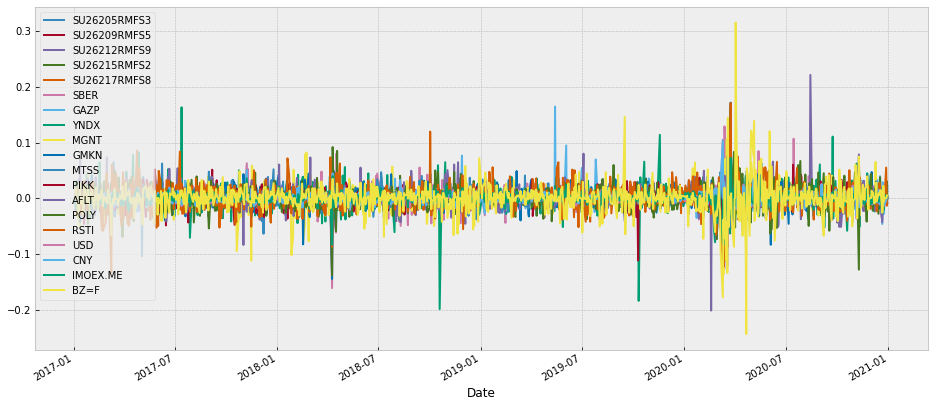

In [165]:
ret.plot(figsize=(16, 7))

plt.show()

In [24]:


for s in share:
    shares = yf.download([s])
    shares.to_csv('shares{}'.format(chr(92)) + s + '.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Exception in thread Thread-96:
Traceback (most recent call last):
  File "E:\Anaconda\lib\site-packages\urllib3\response.py", line 436, in _error_catcher
    yield
  File "E:\Anaconda\lib\site-packages\urllib3\response.py", line 766, in read_chunked
    chunk = self._handle_chunk(amt)
  File "E:\Anaconda\lib\site-packages\urllib3\response.py", line 719, in _handle_chunk
    returned_chunk = self._fp._safe_read(self.chunk_left)
  File "E:\Anaconda\lib\http\client.py", line 614, in _safe_read
    raise IncompleteRead(data, amt-len(data))
http.client.IncompleteRead: IncompleteRead(1335 bytes read, 771 more expected)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "E:\Anaconda\lib\site-packages\requests\models.py", line 751, in generate
    for chunk in self.raw.stream(chunk_size, decode_content=True):
  File "E:\Anaconda\lib\site-packages\urllib3\response.py", line 571, in stream
    for line in self.read_chunked(amt, decode_

In [8]:
df = yf.download(["SBER.ME", 'GAZP.ME', 'YNDX.ME', 'MGNT.ME', 'GMKN.ME',
                  'MTSS.ME', 'PIKK.ME', 'AFLT.ME', 'AFLT.ME', 'RSTI.ME',
                  'RUB=X', 'JPYRUB=X', 'BZ=F', 'IMOEX.ME'], start="2017-01-01", end="2021-01-01")

[*********************100%***********************]  13 of 13 completed


In [9]:
df

Adj Close                                                    \
               AFLT.ME       BZ=F     GAZP.ME       GMKN.ME     IMOEX.ME   
Date                                                                       
2017-01-02         NaN        NaN         NaN           NaN          NaN   
2017-01-03  128.708633  55.470001  119.453156   6927.608887  2285.429932   
2017-01-04  125.925385  56.459999  119.256218   6893.798828  2263.899902   
2017-01-05  125.594444  56.889999  116.650513   6778.846191  2220.350098   
2017-01-06  124.151909  57.099998  116.726257   6788.989746  2213.929932   
...                ...        ...         ...           ...          ...   
2020-12-25   68.919998        NaN  205.460007  23362.000000          NaN   
2020-12-28   69.459999  50.860001  205.910004  23636.000000  3258.949951   
2020-12-29   70.459999  51.090000  209.020004  23638.000000  3274.669922   
2020-12-30   71.339996  51.340000  212.369995  23676.000000  3289.020020   
2020-12-31         NaN        NaN         NaN           NaN          NaN   

                                                                     ...  \
            JPYRUB=X      MGNT.ME     MTSS.ME     PIKK.ME   RSTI.ME  ...   
Date                                                                 ...   
2017-01-02  0.523810          NaN         NaN         NaN       NaN  ...   
2017-01-03  0.521610  8697.368164  159.468582  247.140640  1.060553  ...   
2017-01-04  0.517870  8600.023438  157.434631  245.614563  1.069071  ...   
2017-01-05  0.514930  8335.583008  158.163223  243.155853  1.075143  ...   
2017-01-06  0.514980  8354.746094  156.038177  244.173248  1.091455  ...   
...              ...          ...         ...         ...       ...  ...   
2020-12-25  0.714231  5229.843750  328.500000  587.000000  1.713500  ...   
2020-12-28  0.714540  5340.882812  327.850006  591.599976  1.807700  ...   
2020-12-29  0.712556  5417.940430  331.149994  593.599976  1.783400  ...   
2020-12-30  0.714975  5427.033691  331.500000  596.500000  1.766700  ...   
2020-12-31  0.721931          NaN         NaN         NaN       NaN  ...   

              Volume                                                  \
             GMKN.ME IMOEX.ME JPYRUB=X   MGNT.ME    MTSS.ME  PIKK.ME   
Date                                                                   
2017-01-02       NaN      NaN      0.0       NaN        NaN      NaN   
2017-01-03  187245.0      0.0      0.0  130192.0  1673960.0  26544.0   
2017-01-04  150167.0      0.0      0.0   79263.0  1058490.0  29451.0   
2017-01-05  113459.0      0.0      0.0   99568.0  1290748.0  40281.0   
2017-01-06   76998.0      0.0      0.0   88916.0   914180.0  16951.0   
...              ...      ...      ...       ...        ...      ...   
2020-12-25   44039.0      NaN      0.0  153645.0  1564935.0  18251.0   
2020-12-28  126990.0      0.0      0.0  330618.0  1994751.0  55945.0   
2020-12-29  149179.0      0.0      0.0  399322.0  2516771.0  73261.0   
2020-12-30  115575.0      0.0      0.0  397737.0  2435663.0  53411.0   
2020-12-31       NaN      NaN      0.0       NaN        NaN      NaN   

                                                     
                RSTI.ME RUB=X     SBER.ME   YNDX.ME  
Date                                                 
2017-01-02          NaN   0.0         NaN       NaN  
2017-01-03  190173000.0   0.0  53895668.0   76879.0  
2017-01-04  288250200.0   0.0  41400772.0   38745.0  
2017-01-05  208257001.0   0.0  35093060.0   77016.0  
2017-01-06  202566001.0   0.0  35415591.0   85243.0  
...                 ...   ...         ...       ...  
2020-12-25   29417001.0   0.0  10551258.0   82208.0  
2020-12-28  739033170.0   0.0  36306331.0  283052.0  
2020-12-29  280720006.0   0.0  35803940.0  308583.0  
2020-12-30  249524002.0   0.0  28870050.0  402505.0  
2020-12-31          NaN   0.0         NaN       NaN  

[1044 rows x 78 columns]

Exception in thread Thread-29:
Traceback (most recent call last):
  File "E:\Anaconda\lib\site-packages\urllib3\response.py", line 436, in _error_catcher
    yield
  File "E:\Anaconda\lib\site-packages\urllib3\response.py", line 766, in read_chunked
    chunk = self._handle_chunk(amt)
  File "E:\Anaconda\lib\site-packages\urllib3\response.py", line 719, in _handle_chunk
    returned_chunk = self._fp._safe_read(self.chunk_left)
  File "E:\Anaconda\lib\http\client.py", line 614, in _safe_read
    raise IncompleteRead(data, amt-len(data))
http.client.IncompleteRead: IncompleteRead(4087 bytes read, 9 more expected)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "E:\Anaconda\lib\site-packages\requests\models.py", line 751, in generate
    for chunk in self.raw.stream(chunk_size, decode_content=True):
  File "E:\Anaconda\lib\site-packages\urllib3\response.py", line 571, in stream
    for line in self.read_chunked(amt, decode_co

In [4]:
obligation_rates[0]

,<DATE>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,2017-01-03,98.2480,98.2480,98.0998,98.0998,3465
1,2017-01-06,98.1999,98.2000,98.1999,98.2000,131
2,2017-01-09,98.5997,98.5998,98.1001,98.1002,109
3,2017-01-10,98.4998,98.7500,98.2141,98.7500,323674
4,2017-01-11,98.8499,98.8800,98.2503,98.2503,385356
...,...,...,...,...,...,...
1000,2020-12-24,101.9810,102.0200,101.9500,102.0190,1875712
1001,2020-12-25,101.9900,102.0000,101.9600,102.0000,744348
1002,2020-12-28,102.0000,102.0360,101.9630,102.0300,434595
1003,2020-12-29,102.0500,102.4500,101.9700,102.0780,1001909


# Далее только копия 

# Univariate Risk management


Download `Microsoft` stock price data for a period of `'2016-01-01' -- '2021-02-15'` and calculate VaR and ES curves for $\alpha=10\%$ using different models:

1. Use Generalized normal distribution (check this documenation https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gennorm.html)
2. Use GARCH model with constant mean, EGARCH(p, o, q) and skewed t-student distribution of residuals
    - to select "optimal" set of parameters (p, o, q), do a loop over several possible values and select the best in terms of AIC or Log Likelihood
    - optionally, you can do the same for also selecting the best
        - model for constant
        - GARCH specification
        - distribution of residuals
3. Use a combination of GARCH and Extreme Value Theory: filter time series with GARCH from the previous task, and then model residuals with Excess Distribution Over a Threshold
    - you need to take calculate_VaR_FHS() and "insert" a code from EVT section to the middle


Then plot all VaR curves on one plot, all ES curves on the secong plot, and conduct tests to select the most convenient approach. **Finally, you should deliver**:
1. One graph with daily historical returns and three VaR curves
2. p-value for each model you use for VaR tests
3. One graph with daily historical returns and three ES curves
4. p-value for each model you use for ES tests
5. Conclusion about what approach is the most suitable for this stock

For backtesting ES, you will have to search for appropriate tests. I can propose the following:
- a one-sided test based on the Exceedance Residuals (ER), McNeil and Frey (2000)
- a multilevel VaR backtest, Kratz et al. (2018)

In [28]:
MS = yf.download('EURRUB=X', '2016-01-01','2021-02-15')
MS

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-12-31,79.977699,81.160103,79.728104,79.977699,79.977699,0
2016-01-01,79.853951,79.853951,79.853951,79.853951,79.853951,0
2016-01-04,76.557198,80.396500,75.349297,76.557198,76.557198,0
2016-01-05,78.535202,79.329300,78.377602,78.535202,78.535202,0
2016-01-06,78.630898,80.584000,78.153900,78.630898,78.630898,0
...,...,...,...,...,...,...
2021-02-08,89.831200,89.903397,89.244003,89.831200,89.831200,0
2021-02-09,89.569801,89.771400,89.298103,89.584702,89.584702,0
2021-02-10,89.503197,89.734299,89.316002,89.550598,89.550598,0


Начненем с простой визуализации наших данных. Пока ничего интересного, обычная копия того, что мы проходили на семинарах.

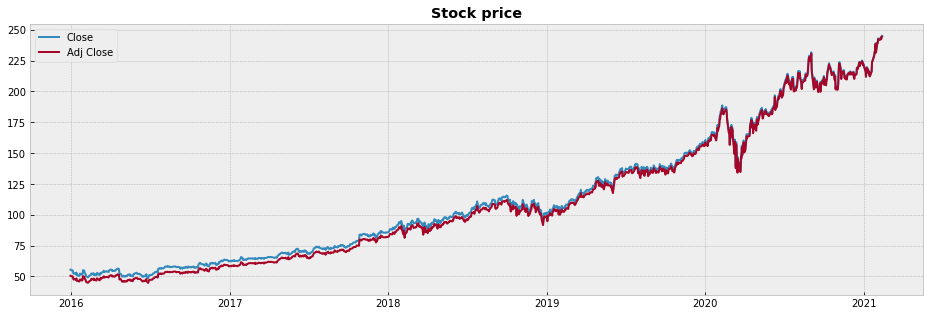

In [3]:
plot_fields = ['Close', 'Adj Close']

fig = plt.figure(figsize=(16, 5))

plt.plot(MS[plot_fields])
plt.legend(plot_fields)

plt.title("Stock price", weight="bold")

plt.show()

In [4]:
price = MS['Adj Close']
ret = price.pct_change()
ret = ret.dropna()

# 0. Исторический подход 

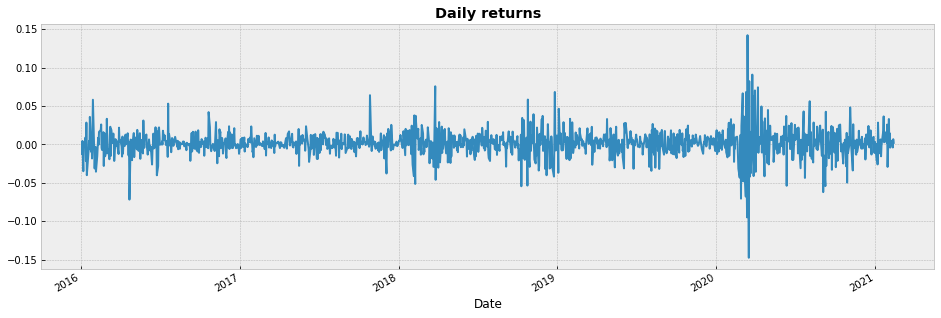

In [5]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
plt.title("Daily returns", weight="bold")

plt.show()

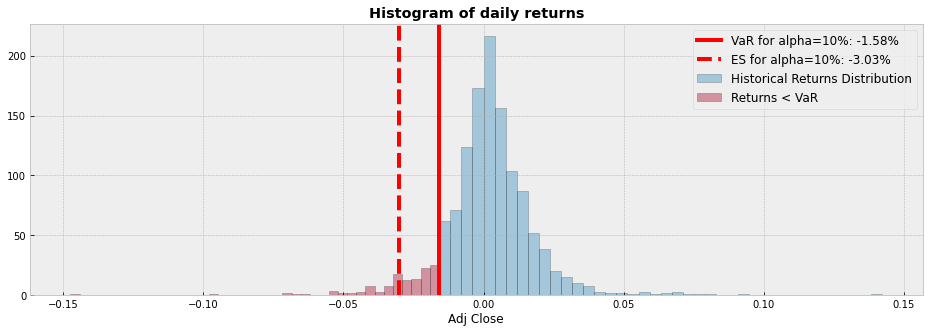

In [6]:
alpha = 0.1
VaR_HS = ret.quantile(alpha)
ES_HS = ret[ret < VaR_HS].mean()

fig = plt.figure(figsize=(16, 5))

sns.distplot(ret[ret >= VaR_HS], hist=True, kde=False, 
             bins=40,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(ret[ret < VaR_HS], hist=True, kde=False, 
             bins=40,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.axvline(x=VaR_HS, linewidth=4, color="r")
plt.axvline(ES_HS, linewidth=4, color='red', linestyle='dashed')

plt.title("Histogram of daily returns", weight="bold")
plt.legend(['VaR for alpha=10%: {:.2f}%'.format(100*VaR_HS),
            'ES for alpha=10%: {:.2f}%'.format(100*ES_HS),
            'Historical Returns Distribution', 
            'Returns < VaR'], fontsize=12)

plt.show()

# 1. Generalized normal distribution

1. Use Generalized normal distribution (check this documenation https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gennorm.html)

In [7]:
from scipy.stats import gennorm

params_gennorm = gennorm.fit(ret)
beta, mean, sigma = params_gennorm
VaR_gennorm = gennorm.ppf(alpha, loc=mean, beta=beta, scale=sigma)
ES_gennorm = gennorm.expect(args = (beta,), loc = mean, scale = sigma, ub = VaR_gennorm, conditional=True)

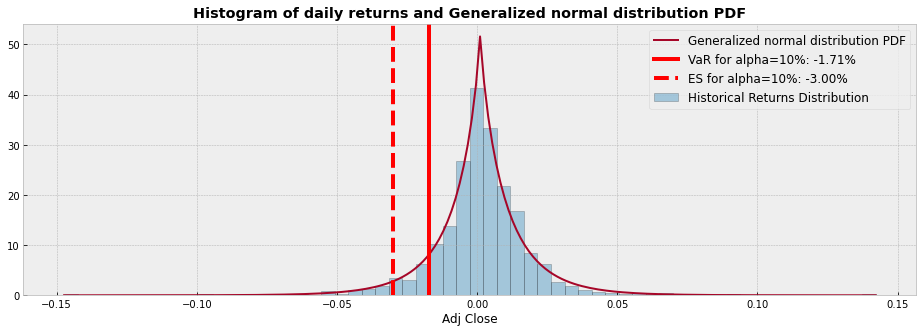

In [8]:
fig = plt.figure(figsize=(16, 5))

x = np.linspace(ret.min(), ret.max(), 200)

y_pdf = gennorm.pdf(x, beta=beta, loc=mean, scale=sigma)

sns.distplot(ret, hist=True, kde=False, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             norm_hist = True)


plt.plot(x, y_pdf)


plt.axvline(x=VaR_gennorm, linewidth=4, color="r")
plt.axvline(x=ES_gennorm, linewidth=4, color="r", linestyle='--')

plt.legend(['Generalized normal distribution PDF',
            'VaR for alpha=10%: {:.2f}%'.format(100*VaR_gennorm),
            'ES for alpha=10%: {:.2f}%'.format(100*ES_gennorm),
            'Historical Returns Distribution'], fontsize=12)

plt.title("Histogram of daily returns and Generalized normal distribution PDF", weight="bold")

plt.show()

Тут я использовал окно в 170 дней. Надеюсь это не слишком мало и не слишком много.

In [9]:
def calc_VaR_and_ES(r, VaR_fun, L_history=170, level=0.1):
    VaR, ES = np.full(r.size, np.nan), np.full(r.size, np.nan)
    
    for i in tqdm(range(L_history, len(r))):
        history = r[i - L_history: i]
        VaR[i] = VaR_fun(history, level)
        ES[i] = history[history < VaR[i]].mean()
    
    VaR = pd.Series(data=VaR, index=r.index, name=VaR_fun.__name__) 
    ES = pd.Series(data=ES, index=r.index, name=VaR_fun.__name__)  
    
    return VaR, ES

def calculate_VaR_HS(ret, alpha=0.1):

    return ret.quantile(alpha)

def calculate_VaR_gennorm(ret, alpha=0.1):

    gennorm_params = gennorm.fit(ret)
    
    return gennorm.ppf(alpha, *gennorm_params)

In [10]:
VaR_HS_series, ES_HS_series = calc_VaR_and_ES(ret, calculate_VaR_HS)
VaR_gennorm_series, ES_gennorm_series = calc_VaR_and_ES(ret, calculate_VaR_gennorm)

100%|██████████| 1118/1118 [00:21<00:00, 51.36it/s]


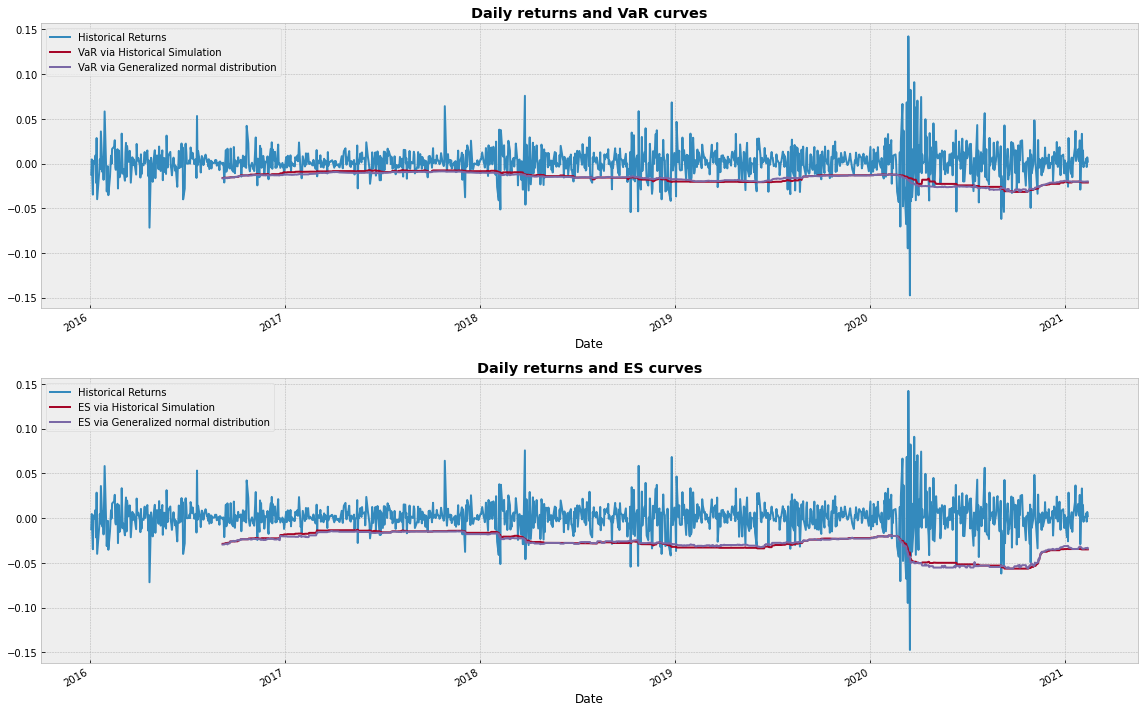

In [11]:
fig = plt.figure(figsize=(16, 10))

plt.subplot(211)
ret.plot()
VaR_HS_series.plot()
VaR_gennorm_series.plot()

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via Historical Simulation',
            'VaR via Generalized normal distribution'])

plt.subplot(212)
ret.plot()
ES_HS_series.plot()
ES_gennorm_series.plot()

plt.title("Daily returns and ES curves", weight="bold")

plt.legend(['Historical Returns',
            'ES via Historical Simulation',
            'ES via Generalized normal distribution'])

plt.tight_layout()
plt.show()

# 2. GARCH model

2. Use GARCH model with constant mean, EGARCH(p, o, q) and skewed t-student distribution of residuals
    - to select "optimal" set of parameters (p, o, q), do a loop over several possible values and select the best in terms of AIC or Log Likelihood
    - optionally, you can do the same for also selecting the best
        - model for constant
        - GARCH specification
        - distribution of residuals

Будем использовать нормирующую константу как в семире. Нормировка на отрезке [0; 1] у меня почему к ничему хорошему не привела. Также будем использовать обычный GARCH поскольку он имеет пораметры (p, o, q), но в отличии от EGARCH не имеет проблем со сходимостью. 

Оптимизировать модель будем путем минимизации AIC.

In [12]:
scaling_const = 10 / ret.std()
def find_params(ps, os, qs):
    best_aic = np.Infinity 
    best_params = (1, 1, 1)
    for p in tqdm(ps):
        p = int(p)
        for o in os:
            o = int(o)
            for q in qs:
                q = int(q)
                mdl = arch_model(y=ret * scaling_const,
                    mean='Constant', lags=1, 
                    vol='GARCH', p=p, o=o, q=q, 
                    dist='skewt') 
                res = mdl.fit(disp = 'off', show_warning=False)
                if res.aic < best_aic:
                    best_aic = res.aic
                    best_params = (p, o, q)
    return best_params

Будем перебирать параметры из отреза [1; 10]. В целом оптимальный отрезок для перебора, не мало и не много, да и слишком много ждать не пришлось. 

In [14]:
ps, os, qs = [np.linspace(1, 10, 10).astype(int) for x in range(3)]
params = find_params(ps, os, qs)

100%|██████████| 10/10 [10:49<00:00, 64.99s/it]


In [15]:
mdl = arch_model(y=ret * scaling_const,
                    mean='Constant', lags=1, 
                    vol='GARCH', p=params[0], o=params[1], q=params[2], 
                    dist='skewt') 
res = mdl.fit(disp = 'off')

In [16]:
forecasts = res.forecast(horizon=1)
cond_mean = float(forecasts.mean.iloc[-1])
cond_var = float(forecasts.variance.iloc[-1])
q = mdl.distribution.ppf(alpha, res.params[-2:])


VaR_garch_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const
ES_garch = ret[ret < VaR_garch_forecast].mean()

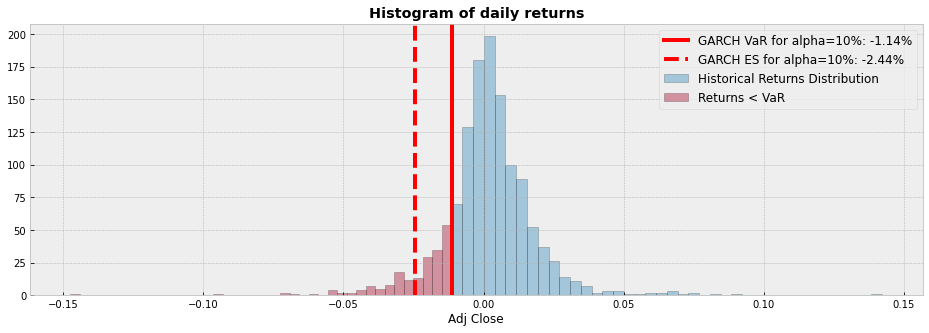

In [17]:
fig = plt.figure(figsize=(16, 5))

sns.distplot(ret[ret >= VaR_garch_forecast], hist=True, kde=False, 
             bins=40,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(ret[ret < VaR_garch_forecast], hist=True, kde=False, 
             bins=40,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.axvline(VaR_garch_forecast, linewidth=4, color="r")
plt.axvline(ES_garch, linewidth=4, color='r', linestyle='dashed')

plt.title("Histogram of daily returns", weight="bold")
plt.legend(['GARCH VaR for alpha=10%: {:.2f}%'.format(100*VaR_garch_forecast),
            'GARCH ES for alpha=10%: {:.2f}%'.format(100*ES_garch),
            'Historical Returns Distribution', 
            'Returns < VaR'], fontsize=12)

plt.show()

In [18]:
def calculate_VaR_garch(returns, alpha):
    mdl = arch_model(returns * scaling_const,
                    mean='Constant', lags=1, 
                    vol='GARCH', p=params[0], o=params[1], 
                    q=params[2], dist='skewt') 
    
    res = mdl.fit(disp='off', show_warning=False)

    forecasts = res.forecast(horizon=1)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    q = mdl.distribution.ppf(alpha, res.params[-2:])

    VaR_garch_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const

    return VaR_garch_forecast

VaR_GARCH_series, ES_GARCH_series = calc_VaR_and_ES(ret, calculate_VaR_garch, 170)

100%|██████████| 1118/1118 [03:27<00:00,  5.38it/s]


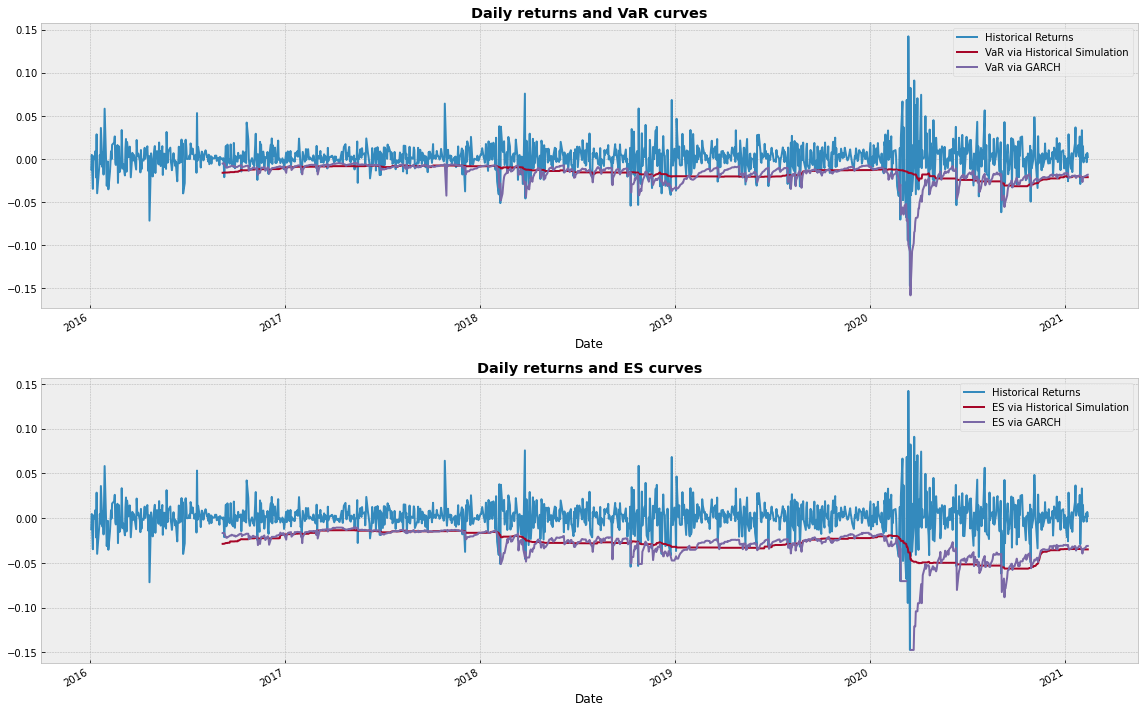

In [19]:
fig = plt.figure(figsize=(16, 10))

plt.subplot(211)
ret.plot()
VaR_HS_series.plot()
VaR_GARCH_series.plot()

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via Historical Simulation',
            'VaR via GARCH'])

plt.subplot(212)
ret.plot()
ES_HS_series.plot()
ES_GARCH_series.plot()

plt.title("Daily returns and ES curves", weight="bold")

plt.legend(['Historical Returns',
            'ES via Historical Simulation',
            'ES via GARCH'])

plt.tight_layout()
plt.show()

# 3. GARCH and Extreme Value Theory
3. Use a combination of GARCH and Extreme Value Theory: filter time series with GARCH from the previous task, and then model residuals with Excess Distribution Over a Threshold
    - you need to take calculate_VaR_FHS() and "insert" a code from EVT section to the middle

Вот тут было сложно и непонятно, не очевидно как использовать Extreme Value Theory, но я попытался. 

In [20]:
mdl = arch_model(y=ret * scaling_const,
                    mean='Constant', lags=1, 
                    vol='GARCH', p=params[0], o=params[1], q=params[2], 
                    dist='skewt') 
res = mdl.fit(disp = 'off')

In [21]:
from scipy.stats import genpareto

stand_residuals = res.resid / res.conditional_volatility
stand_residuals = stand_residuals.dropna()

u = stand_residuals.quantile(2*alpha)
stand_residuals_tail = stand_residuals[stand_residuals <= u]
params_genpareto = genpareto.fit(-stand_residuals_tail, loc=0)
c, loc, scale = params_genpareto
genpareto.ppf(alpha, loc=loc, scale=scale, c=c)

stand_residuals = -genpareto.rvs(loc=loc, scale=scale, c=c, size = ret.shape)
stand_residuals = pd.Series(data=stand_residuals, index=ret.index) 

forecasts = res.forecast(horizon=1)
cond_mean = float(forecasts.mean.iloc[-1])
cond_var = float(forecasts.variance.iloc[-1])

conditional_sr = cond_mean + np.sqrt(cond_var) * stand_residuals
conditional_sr = conditional_sr / scaling_const

VaR_Garch_EVT = conditional_sr.quantile(2*alpha)
ES_Garch_EVT = ret[ret < VaR_Garch_EVT].mean()

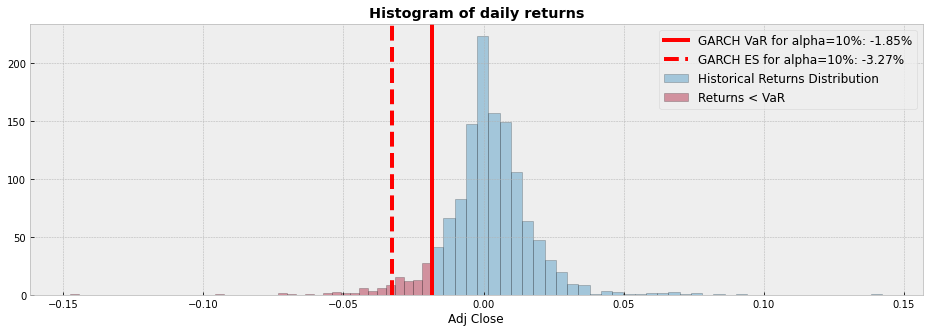

In [22]:
fig = plt.figure(figsize=(16, 5))

sns.distplot(ret[ret >= VaR_Garch_EVT], hist=True, kde=False, 
             bins=40,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(ret[ret < VaR_Garch_EVT], hist=True, kde=False, 
             bins=40,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.axvline(VaR_Garch_EVT, linewidth=4, color="r")
plt.axvline(ES_Garch_EVT, linewidth=4, color='r', linestyle='dashed')

plt.title("Histogram of daily returns", weight="bold")
plt.legend(['GARCH VaR for alpha=10%: {:.2f}%'.format(100*VaR_Garch_EVT),
            'GARCH ES for alpha=10%: {:.2f}%'.format(100*ES_Garch_EVT),
            'Historical Returns Distribution', 
            'Returns < VaR'], fontsize=12)

plt.show()

In [23]:
def calculate_VaR_FHS_EVT(returns, alpha=0.1):

    mdl = arch_model(y=returns * scaling_const,
                    mean='Constant', lags=1, 
                    vol='GARCH', p=params[0], o=params[1], q=params[2], 
                    dist='skewt') 

    res = mdl.fit(disp='off')

    stand_residuals = res.resid / res.conditional_volatility
    stand_residuals = stand_residuals.dropna()
    
    u = stand_residuals.quantile(2*alpha)
    stand_residuals_tail = stand_residuals[stand_residuals <= u]
    params_genpareto = genpareto.fit(-stand_residuals_tail, loc=0)
    c, loc, scale = params_genpareto
    genpareto.ppf(alpha, loc=loc, scale=scale, c=c)

    stand_residuals = -genpareto.rvs(loc=loc, scale=scale, c=c, size = ret.shape)
    stand_residuals = pd.Series(data=stand_residuals, index=ret.index) 

    forecasts = res.forecast(horizon=1)
    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    conditional_sr = cond_mean + np.sqrt(cond_var) * stand_residuals
    conditional_sr = conditional_sr / scaling_const 

    VaR_GARCH_EVT = conditional_sr.quantile(2*alpha)

    return VaR_GARCH_EVT

VaR_GARCH_EVT_series, ES_GARCH_EVT_series = calc_VaR_and_ES(ret, calculate_VaR_FHS_EVT, 170)

100%|██████████| 1118/1118 [06:02<00:00,  3.09it/s]


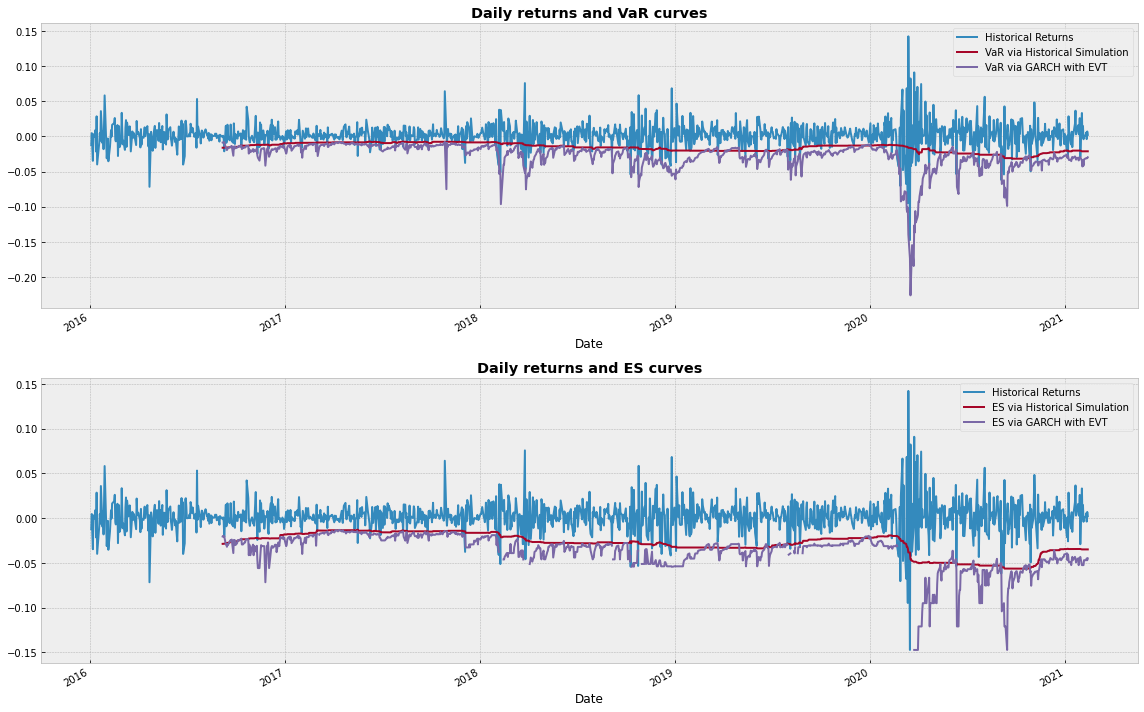

In [24]:
fig = plt.figure(figsize=(16, 10))

plt.subplot(211)
ret.plot()
VaR_HS_series.plot()
VaR_GARCH_EVT_series.plot()


plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via Historical Simulation',
            'VaR via GARCH with EVT'])

plt.subplot(212)
ret.plot()
ES_HS_series.plot()
ES_GARCH_EVT_series.plot()


plt.title("Daily returns and ES curves", weight="bold")

plt.legend(['Historical Returns',
            'ES via Historical Simulation',
            'ES via GARCH with EVT'])

plt.tight_layout()
plt.show()

# 4. Plotting Curves and Backtesting

Then plot all VaR curves on one plot, all ES curves on the secong plot, and conduct tests to select the most convenient approach. **Finally, you should deliver**:
1. One graph with daily historical returns and three VaR curves
2. p-value for each model you use for VaR tests
3. One graph with daily historical returns and three ES curves
4. p-value for each model you use for ES tests
5. Conclusion about what approach is the most suitable for this stock

For backtesting ES, you will have to search for appropriate tests. I can propose the following:
- a one-sided test based on the Exceedance Residuals (ER), McNeil and Frey (2000)
- a multilevel VaR backtest, Kratz et al. (2018)

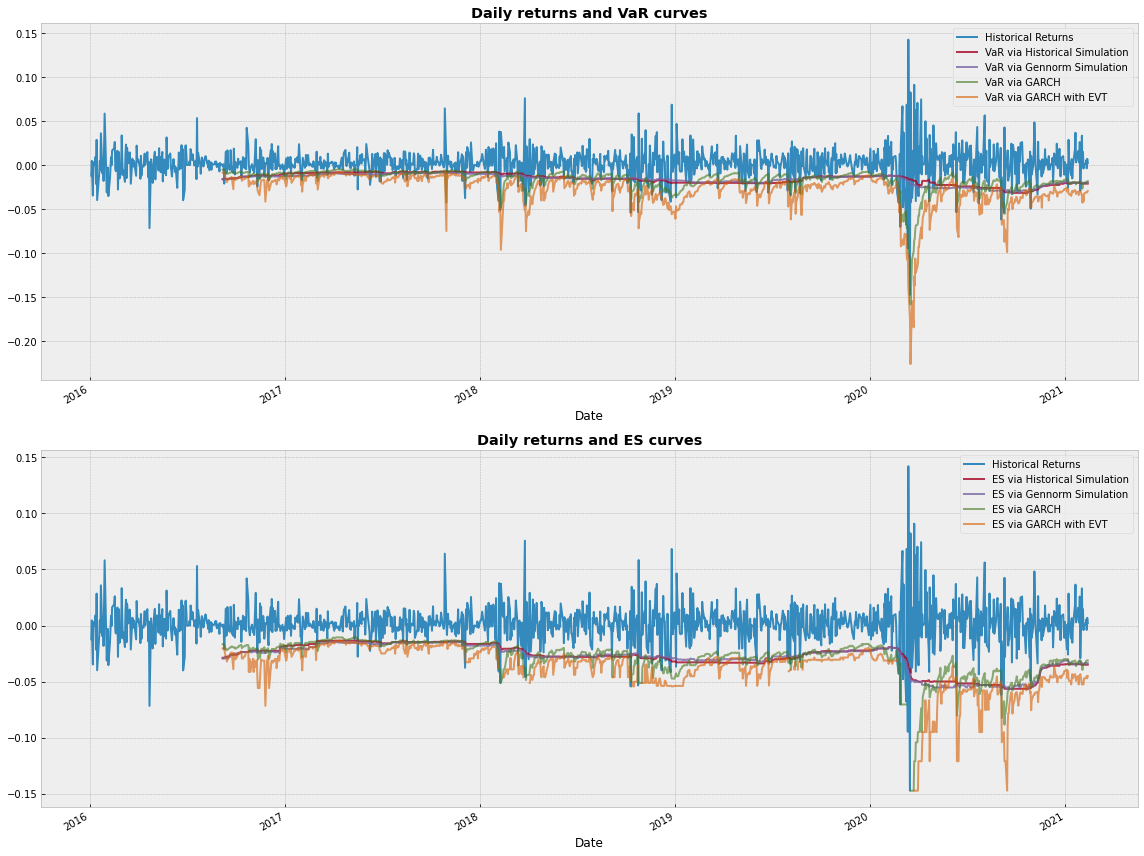

In [25]:
fig = plt.figure(figsize=(16, 12))

plt.subplot(211)
ret.plot()
VaR_HS_series.plot(alpha=0.8)
VaR_gennorm_series.plot(alpha=0.8)
VaR_GARCH_series.plot(alpha=0.6)
VaR_GARCH_EVT_series.plot(alpha=0.6)

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via Historical Simulation',
            'VaR via Gennorm Simulation',
            'VaR via GARCH',
            'VaR via GARCH with EVT'])

plt.subplot(212)
ret.plot()
ES_HS_series.plot(alpha=0.8)
ES_gennorm_series.plot(alpha=0.8)
ES_GARCH_series.plot(alpha=0.6)
ES_GARCH_EVT_series.plot(alpha=0.6)

plt.title("Daily returns and ES curves", weight="bold")

plt.legend(['Historical Returns',
            'ES via Historical Simulation',
            'ES via Gennorm Simulation',
            'ES via GARCH',
            'ES via GARCH with EVT'])

plt.tight_layout()
plt.show()

In [26]:
from scipy.stats import chi2

def bern_test(p, v):
    
    lv = len(v)
    sv = sum(v)
    al = np.log(p)*sv + np.log(1-p)*(lv-sv)
    
    bl = np.log(sv/lv)*sv + np.log(1-sv/lv)*(lv-sv)
    
    return (-2*(al-bl))


def ind_test(V):
    
    J = np.full([len(V),4], 0)
    for i in range(1,len(V)-1):
        J[i,0] = (V[i-1] == 0) & (V[i] == 0)
        J[i,1] = (V[i-1] == 0) & (V[i] == 1)
        J[i,2] = (V[i-1] == 1) & (V[i] == 0)
        J[i,3] = (V[i-1] == 1) & (V[i] == 1)
        
    V_00 = sum(J[:,0])
    V_01 = sum(J[:,1])
    V_10 = sum(J[:,2])
    V_11 = sum(J[:,3])
    p_00=V_00/(V_00+V_01)
    p_01=V_01/(V_00+V_01)
    p_10=V_10/(V_10+V_11)
    p_11=V_11/(V_10+V_11)
    hat_p = (V_01+V_11)/(V_00+V_01+V_10+V_11)
    al = np.log(1-hat_p)*(V_00+V_10) + np.log(hat_p)*(V_01+V_11)
    bl = np.log(p_00)*V_00 + np.log(p_01)*V_01 + np.log(p_10)*V_10 + np.log(p_11)*V_11
    
    return (-2*(al-bl))

def backtest_results(ret, var_curves,curves_names, alpha, significance=0.95):
    i = 0
    for var_curve in var_curves:
        idx = var_curve.notna()

        violations = ret[idx] < var_curve[idx]

        coverage = bern_test(p=alpha, v=violations) < chi2.ppf(significance, 1)
        independence = ind_test(violations) < chi2.ppf(significance, 1)
        
        print(curves_names[i] + ' results:')
        
        print('Target share of violations: {:.2f}%'.format(100*alpha))
        print('Observed share of violations: {:.2f}%'.format(100*violations.mean()))

        print('')

        if coverage:
            print('Test for coverage is passed')
        else:
            print('Test for coverage isn\'t passed')

        print('')

        if independence:
            print('Test for independence is passed')
        else:
            print('Test for independence isn\'t passed')
            
        print('_______________________________________________')
        i+= 1

In [28]:
backtest_results(
    ret, 
    var_curves=[VaR_HS_series, VaR_gennorm_series, VaR_GARCH_series, VaR_GARCH_EVT_series],
    curves_names = ['VaR_HS_series', 'VaR_gennorm_series', 'VaR_GARCH_series', 'VaR_GARCH_EVT_series'], 
    alpha=alpha, 
    significance=0.9
)

VaR_HS_series results:
Target share of violations: 10.00%
Observed share of violations: 10.64%

Test for coverage is passed

Test for independence isn't passed
_______________________________________________
VaR_gennorm_series results:
Target share of violations: 10.00%
Observed share of violations: 10.38%

Test for coverage is passed

Test for independence isn't passed
_______________________________________________
VaR_GARCH_series results:
Target share of violations: 10.00%
Observed share of violations: 10.91%

Test for coverage is passed

Test for independence is passed
_______________________________________________
VaR_GARCH_EVT_series results:
Target share of violations: 10.00%
Observed share of violations: 4.38%

Test for coverage isn't passed

Test for independence is passed
_______________________________________________


Для бектеста выбрал уровень значимости такой, который показывает преимущество GARCH над исторической симуляцией и обобщённым нормальным распределением. При таком уровне значимости у Гарча не наблюдаются проблемы не со сходимостью и с независимостью. 

GARCH с Extreme Value Theory показывает очень плохие результаты, закладывая очень большие риски в модель. Скорее всего не модель плохая, а я до конца не понял, как моделировать правильно EVT. Отсюда и плохие результаты.
